Although it's going to be a bit redundant for the sake of simplicity we're going to recreate the classes from previous notbooks here:

In [44]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.amp import GradScaler, autocast
from tqdm import tqdm

from pycocotools.coco import COCO
from pycocotools import mask as mask_util

import albumentations as A
from albumentations.pytorch import ToTensorV2

Albumentations Transforms

In [45]:
# IMPORTANT:
# Resizing to 256×256 dramatically speeds up training

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.10,
        rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.5
    ),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

Polygon → Mask (COCO conversion):

In [46]:
def polygons_to_mask(anns, height, width):
    """
    Convert COCO polygon annotations into a binary mask.
    The dataset uses rectangular polygons, but the logic remains the same.
    """
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        rles = mask_util.frPyObjects(ann["segmentation"], height, width)
        rle = mask_util.merge(rles)
        m = mask_util.decode(rle)
        mask = np.maximum(mask, m)

    return mask

 Dataset Class (TRAIN + VALID)

In [47]:
class BrainTumorDataset(Dataset):
    """
    Loads:
      - Image: RGB
      - Mask: binary mask generated from COCO polygons
    Applies Albumentations transforms with correct (image,mask) pairing.
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        ann_path = os.path.join(root_dir, "_annotations.coco.json")
        self.coco = COCO(ann_path)
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):

        # -----------------------------------------------------
        # Load COCO image metadata
        # -----------------------------------------------------
        img_id = self.image_ids[index]
        info = self.coco.imgs[img_id]

        file_name = info["file_name"]
        height = info["height"]
        width  = info["width"]

        # Load image
        img_path = os.path.join(self.root_dir, file_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # -----------------------------------------------------
        # Load annotations → polygon → mask
        # -----------------------------------------------------
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        mask = polygons_to_mask(anns, height, width).astype(np.uint8)
        mask = np.expand_dims(mask, axis=2)   # HWC (Albumentations format)

        # -----------------------------------------------------
        # Albumentations transform (image, mask)
        # -----------------------------------------------------
        if self.transform:
            data = self.transform(image=image, mask=mask)
            image = data["image"]           # CHW tensor
            mask  = data["mask"]            # HWC tensor

            # FIX: Convert mask from HWC → CHW
            if mask.ndim == 3:
                mask = mask.permute(2, 0, 1)

        return image.float(), mask.float()

Test Dataset (no masks)

In [48]:
class BrainTumorTestDataset(Dataset):
    """
    Loads test images (no annotation file).
    Returns:
      - Image tensor
      - Filename (used to save outputs)
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = sorted([
            f for f in os.listdir(root_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fn = self.filenames[idx]
        path = os.path.join(self.root_dir, fn)

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image.float(), fn

U-Net Model

In [49]:
class DoubleConv(nn.Module):
    """Conv → BN → ReLU → Conv → BN → ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """MaxPool → DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upsample → Conv(1x1) → concat skip → DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv1x1 = nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=1)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):

        x1 = self.up(x1)
        x1 = self.conv1x1(x1)

        # Handle padding mismatch due to odd numbers
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    """Full U-Net"""
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.out(x)

Loss + Metrics

In [50]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice = (2 * intersection + self.smooth) / \
               (probs.sum() + targets.sum() + self.smooth)

        return 1 - dice


class BCEDiceLoss(nn.Module):
    """Recommended loss for medical segmentation"""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, logits, targets):
        return self.bce(logits, targets) + self.dice(logits, targets)


def threshold_mask(logits, thr=0.5):
    return (torch.sigmoid(logits) > thr).float()


def compute_iou(logits, targets):
    preds = threshold_mask(logits)
    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return ((intersection + 1e-6) / (union + 1e-6)).item()


def compute_pixel_accuracy(logits, targets):
    preds = threshold_mask(logits)
    preds = preds.view(-1)
    targets = targets.view(-1)
    return (preds == targets).float().mean().item()

Load Dataset Loaders

In [51]:
train_dataset = BrainTumorDataset("../dataset/train", transform=train_transform)
val_dataset   = BrainTumorDataset("../dataset/valid", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print("Train samples:", len(train_dataset))
print("Valid samples:", len(val_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train samples: 1502
Valid samples: 429


Device + Model + Optimizer

In [52]:
# MPS is the GPU on Apple Silicon
if torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Using device:", DEVICE)

model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.5, verbose=True
)

Using device: mps


Training & Validation Loops

In [53]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        # FP16 automatic casting for speed on MPS
        with autocast(device_type="mps", dtype=torch.float16):
            logits = model(images)
            loss = criterion(logits, masks)

        # NO GradScaler on MPS — unnecessary
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate_one_epoch(model, loader):
    model.eval()
    v_loss = v_iou = v_acc = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits = model(images)
            loss = criterion(logits, masks)

            v_loss += loss.item()
            v_iou  += compute_iou(logits, masks)
            v_acc  += compute_pixel_accuracy(logits, masks)

    n = len(loader)
    return v_loss/n, v_iou/n, v_acc/n

Main Training Loop

In [ ]:
# best_iou = 0
# early_counter = 0

# checkpoint_path = "../experiments/best_model.pth"

# for epoch in range(1, 51):
#     print(f"\n======== EPOCH {epoch} / 50 ========")

#     train_loss = train_one_epoch(model, train_loader)
#     val_loss, val_iou, val_acc = validate_one_epoch(model, val_loader)

#     print(f" Train Loss: {train_loss:.4f}")
#     print(f" Val Loss:   {val_loss:.4f}")
#     print(f" Val IoU:    {val_iou:.4f}")
#     print(f" Val Acc:    {val_acc:.4f}")

#     scheduler.step(val_iou)

#     if val_iou > best_iou:
#         print(f"🔥 IoU improved {best_iou:.4f} → {val_iou:.4f}")
#         best_iou = val_iou
#         early_counter = 0
#         torch.save(model.state_dict(), checkpoint_path)
#         print("💾 Saved best model.")
#     else:
#         early_counter += 1
#         print(f"No improvement: {early_counter} / 8")

#     if early_counter >= 8:
#         print("⛔ Early stopping triggered.")
#         break

# print("\nTraining finished.")
# print("Best IoU achieved:", best_iou)


======== EPOCH 1 / 50 ========


Validating: 100%|██████████| 108/108 [00:03<00:00, 28.16it/s]


 Train Loss: 1.1659
 Val Loss:   1.0835
 Val IoU:    0.2088
 Val Acc:    0.9028
🔥 IoU improved 0.0000 → 0.2088
💾 Saved best model.

======== EPOCH 2 / 50 ========


Validating: 100%|██████████| 108/108 [00:03<00:00, 27.58it/s]


 Train Loss: 0.9240
 Val Loss:   0.9648
 Val IoU:    0.2107
 Val Acc:    0.9335
🔥 IoU improved 0.2088 → 0.2107
💾 Saved best model.

======== EPOCH 3 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 26.92it/s]


 Train Loss: 0.7706
 Val Loss:   0.7940
 Val IoU:    0.3036
 Val Acc:    0.9653
🔥 IoU improved 0.2107 → 0.3036
💾 Saved best model.

======== EPOCH 4 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 25.11it/s]


 Train Loss: 0.6578
 Val Loss:   0.6657
 Val IoU:    0.3995
 Val Acc:    0.9719
🔥 IoU improved 0.3036 → 0.3995
💾 Saved best model.

======== EPOCH 5 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.53it/s]


 Train Loss: 0.5755
 Val Loss:   0.5532
 Val IoU:    0.4530
 Val Acc:    0.9747
🔥 IoU improved 0.3995 → 0.4530
💾 Saved best model.

======== EPOCH 6 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.42it/s]


 Train Loss: 0.5550
 Val Loss:   0.5322
 Val IoU:    0.4607
 Val Acc:    0.9743
🔥 IoU improved 0.4530 → 0.4607
💾 Saved best model.

======== EPOCH 7 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.31it/s]


 Train Loss: 0.5265
 Val Loss:   0.5365
 Val IoU:    0.4500
 Val Acc:    0.9692
No improvement: 1 / 8

======== EPOCH 8 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.24it/s]


 Train Loss: 0.5098
 Val Loss:   0.5258
 Val IoU:    0.4653
 Val Acc:    0.9766
🔥 IoU improved 0.4607 → 0.4653
💾 Saved best model.

======== EPOCH 9 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.16it/s]


 Train Loss: 0.4885
 Val Loss:   0.4562
 Val IoU:    0.5158
 Val Acc:    0.9775
🔥 IoU improved 0.4653 → 0.5158
💾 Saved best model.

======== EPOCH 10 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.94it/s]


 Train Loss: 0.4824
 Val Loss:   0.4536
 Val IoU:    0.5139
 Val Acc:    0.9760
No improvement: 1 / 8

======== EPOCH 11 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.77it/s]


 Train Loss: 0.4720
 Val Loss:   0.4353
 Val IoU:    0.5388
 Val Acc:    0.9792
🔥 IoU improved 0.5158 → 0.5388
💾 Saved best model.

======== EPOCH 12 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.82it/s]


 Train Loss: 0.4556
 Val Loss:   0.4783
 Val IoU:    0.5012
 Val Acc:    0.9785
No improvement: 1 / 8

======== EPOCH 13 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.56it/s]


 Train Loss: 0.4644
 Val Loss:   0.4981
 Val IoU:    0.4694
 Val Acc:    0.9757
No improvement: 2 / 8

======== EPOCH 14 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.46it/s]


 Train Loss: 0.4455
 Val Loss:   0.4557
 Val IoU:    0.5216
 Val Acc:    0.9784
No improvement: 3 / 8

======== EPOCH 15 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.44it/s]


 Train Loss: 0.4384
 Val Loss:   0.4369
 Val IoU:    0.5365
 Val Acc:    0.9799
No improvement: 4 / 8

======== EPOCH 16 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.27it/s]


 Train Loss: 0.3984
 Val Loss:   0.3955
 Val IoU:    0.5677
 Val Acc:    0.9788
🔥 IoU improved 0.5388 → 0.5677
💾 Saved best model.

======== EPOCH 17 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.83it/s]


 Train Loss: 0.3967
 Val Loss:   0.3968
 Val IoU:    0.5692
 Val Acc:    0.9809
🔥 IoU improved 0.5677 → 0.5692
💾 Saved best model.

======== EPOCH 18 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.30it/s]


 Train Loss: 0.3805
 Val Loss:   0.3941
 Val IoU:    0.5717
 Val Acc:    0.9798
🔥 IoU improved 0.5692 → 0.5717
💾 Saved best model.

======== EPOCH 19 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.56it/s]


 Train Loss: 0.3864
 Val Loss:   0.3808
 Val IoU:    0.5797
 Val Acc:    0.9808
🔥 IoU improved 0.5717 → 0.5797
💾 Saved best model.

======== EPOCH 20 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.57it/s]


 Train Loss: 0.3765
 Val Loss:   0.3805
 Val IoU:    0.5873
 Val Acc:    0.9818
🔥 IoU improved 0.5797 → 0.5873
💾 Saved best model.

======== EPOCH 21 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.01it/s]


 Train Loss: 0.3701
 Val Loss:   0.3660
 Val IoU:    0.5976
 Val Acc:    0.9823
🔥 IoU improved 0.5873 → 0.5976
💾 Saved best model.

======== EPOCH 22 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.88it/s]


 Train Loss: 0.3655
 Val Loss:   0.3847
 Val IoU:    0.5765
 Val Acc:    0.9813
No improvement: 1 / 8

======== EPOCH 23 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.03it/s]


 Train Loss: 0.3595
 Val Loss:   0.3888
 Val IoU:    0.5722
 Val Acc:    0.9822
No improvement: 2 / 8

======== EPOCH 24 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.82it/s]


 Train Loss: 0.3657
 Val Loss:   0.3593
 Val IoU:    0.5912
 Val Acc:    0.9803
No improvement: 3 / 8

======== EPOCH 25 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.10it/s]


 Train Loss: 0.3683
 Val Loss:   0.3940
 Val IoU:    0.5670
 Val Acc:    0.9817
No improvement: 4 / 8

======== EPOCH 26 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.50it/s]


 Train Loss: 0.3398
 Val Loss:   0.3561
 Val IoU:    0.5995
 Val Acc:    0.9820
🔥 IoU improved 0.5976 → 0.5995
💾 Saved best model.

======== EPOCH 27 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 21.72it/s]


 Train Loss: 0.3319
 Val Loss:   0.3606
 Val IoU:    0.5948
 Val Acc:    0.9828
No improvement: 1 / 8

======== EPOCH 28 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.94it/s]


 Train Loss: 0.3273
 Val Loss:   0.3582
 Val IoU:    0.5983
 Val Acc:    0.9822
No improvement: 2 / 8

======== EPOCH 29 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.70it/s]


 Train Loss: 0.3354
 Val Loss:   0.3641
 Val IoU:    0.5941
 Val Acc:    0.9821
No improvement: 3 / 8

======== EPOCH 30 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.17it/s]


 Train Loss: 0.3307
 Val Loss:   0.3467
 Val IoU:    0.6079
 Val Acc:    0.9829
🔥 IoU improved 0.5995 → 0.6079
💾 Saved best model.

======== EPOCH 31 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.86it/s]


 Train Loss: 0.3424
 Val Loss:   0.3496
 Val IoU:    0.6079
 Val Acc:    0.9828
No improvement: 1 / 8

======== EPOCH 32 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.18it/s]


 Train Loss: 0.3308
 Val Loss:   0.3648
 Val IoU:    0.5925
 Val Acc:    0.9827
No improvement: 2 / 8

======== EPOCH 33 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 24.11it/s]


 Train Loss: 0.3321
 Val Loss:   0.3595
 Val IoU:    0.5970
 Val Acc:    0.9816
No improvement: 3 / 8

======== EPOCH 34 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 21.62it/s]


 Train Loss: 0.3381
 Val Loss:   0.3994
 Val IoU:    0.5643
 Val Acc:    0.9813
No improvement: 4 / 8

======== EPOCH 35 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 21.91it/s]


 Train Loss: 0.3269
 Val Loss:   0.3582
 Val IoU:    0.5969
 Val Acc:    0.9825
No improvement: 5 / 8

======== EPOCH 36 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.45it/s]


 Train Loss: 0.3263
 Val Loss:   0.3437
 Val IoU:    0.6116
 Val Acc:    0.9828
🔥 IoU improved 0.6079 → 0.6116
💾 Saved best model.

======== EPOCH 37 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.32it/s]


 Train Loss: 0.3302
 Val Loss:   0.3568
 Val IoU:    0.6007
 Val Acc:    0.9818
No improvement: 1 / 8

======== EPOCH 38 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.14it/s]


 Train Loss: 0.3369
 Val Loss:   0.3960
 Val IoU:    0.5675
 Val Acc:    0.9807
No improvement: 2 / 8

======== EPOCH 39 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.26it/s]


 Train Loss: 0.3565
 Val Loss:   0.4178
 Val IoU:    0.5542
 Val Acc:    0.9794
No improvement: 3 / 8

======== EPOCH 40 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 22.90it/s]


 Train Loss: 0.3591
 Val Loss:   0.3907
 Val IoU:    0.5725
 Val Acc:    0.9815
No improvement: 4 / 8

======== EPOCH 41 / 50 ========


Validating: 100%|██████████| 108/108 [00:04<00:00, 23.57it/s]


 Train Loss: 0.3415
 Val Loss:   0.3681
 Val IoU:    0.5878
 Val Acc:    0.9814
No improvement: 5 / 8

======== EPOCH 42 / 50 ========


Validating: 100%|██████████| 108/108 [00:05<00:00, 20.07it/s]


 Train Loss: 0.3366
 Val Loss:   0.3715
 Val IoU:    0.5854
 Val Acc:    0.9821
No improvement: 6 / 8

======== EPOCH 43 / 50 ========


Validating: 100%|██████████| 108/108 [00:05<00:00, 20.14it/s]


 Train Loss: 0.3361
 Val Loss:   0.3678
 Val IoU:    0.5901
 Val Acc:    0.9823
No improvement: 7 / 8

======== EPOCH 44 / 50 ========


Validating: 100%|██████████| 108/108 [00:05<00:00, 20.91it/s]

 Train Loss: 0.3455
 Val Loss:   0.3662
 Val IoU:    0.5907
 Val Acc:    0.9824
No improvement: 8 / 8
⛔ Early stopping triggered.

Training finished.
Best IoU achieved: 0.6116174409795617


***

The best result we got so far is:"0.6116" likely bcs our dataset usees rectangular bounding-box polygons so this is effectively tumor detection, not organic tumor boundaries.

Right now the model is:
- Too shallow for 256×256
- Possibly undertrained
- Loss not optimized
- Threshold too rigid

Improvement A: High-Resolution Transforms (640×640)

In [70]:
# ==========================================================
# IMPROVEMENT A:
# Restore high-resolution images (640 × 640)
# This boosts IoU significantly for rectangular masks.
# ==========================================================

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

balanced_train_transform_safe = A.Compose([
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

balanced_val_transform_safe = A.Compose([
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

print("High-resolution transforms ready (384x384).")

High-resolution transforms ready (384x384).


IMPROVEMENT B — Wider U-Net (More Capacity)

In [71]:
# ==========================================================
# IMPROVEMENT B:
# Wider, deeper U-Net for higher IoU.
# Doubles all channel counts.
# ==========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConvWide(nn.Module):
    """Two convolution blocks: Conv → BN → ReLU repeated"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.net(x)


class DownWide(nn.Module):
    """MaxPool → DoubleConvWide"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvWide(in_channels, out_channels)
        )
    def forward(self, x):
        return self.net(x)


class UpWide(nn.Module):
    """Upsample → 1x1 conv → concat with skip → DoubleConvWide"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv1x1 = nn.Conv2d(in_channels // 2, in_channels // 2, 1)
        self.double_conv = DoubleConvWide(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv1x1(x1)

        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)


class UNetWide(nn.Module):
    """
    High-capacity U-Net for improved IoU.
    All layers doubled in width.
    """
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        # Balanced channels
        self.inc = DoubleConvWide(n_channels, 96)
        self.down1 = DownWide(96, 192)
        self.down2 = DownWide(192, 384)
        self.down3 = DownWide(384, 768)
        self.down4 = DownWide(768, 768)

        self.up1 = UpWide(1536, 384)
        self.up2 = UpWide(768, 192)
        self.up3 = UpWide(384, 96)
        self.up4 = UpWide(192, 96)

        self.out = nn.Conv2d(96, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.out(x)

print("High-capacity UNetWide model ready.")

High-capacity UNetWide model ready.


Create training with high-res + wide U-Net (A+B)

In [72]:
# ==========================================================
# Build NEW dataloaders & NEW model using improvements A + B
# Without overwriting old variables.
# ==========================================================

# Dataset with new transforms
train_dataset_D = BrainTumorDataset("../dataset/train", transform=balanced_train_transform_safe)
val_dataset_D   = BrainTumorDataset("../dataset/valid", transform=balanced_val_transform_safe)

train_loader_D = DataLoader(train_dataset_D, batch_size=4, shuffle=True, num_workers=0)
val_loader_D   = DataLoader(val_dataset_D, batch_size=4, shuffle=False, num_workers=0)

train_loader_AB = DataLoader(train_dataset_D, batch_size=4, shuffle=True, num_workers=0)
val_loader_AB   = DataLoader(val_dataset_D, batch_size=4, shuffle=False, num_workers=0)

print("Datasets for A+B loaded.")

# Model for A+B
model_AB = UNetWide().to(DEVICE)

# Optimizer
optimizer_AB = optim.Adam(model_AB.parameters(), lr=1e-4)

# Loss (same)
criterion_AB = BCEDiceLoss()

# LR scheduler
scheduler_AB = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_AB,
    mode="max",
    patience=4,
    factor=0.5,
    verbose=True
)

print("Model, optimizer, scheduler for A+B ready.")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Datasets for A+B loaded.
Model, optimizer, scheduler for A+B ready.


Train Improved A+B Model

In [73]:
# ==========================================================
# Train improved UNetWide on 640×640 images (A+B)
# ==========================================================

best_iou_AB = 0
early_counter_AB = 0
MAX_EPOCHS_AB = 40
PATIENCE_AB = 10

checkpoint_AB = "../experiments/best_model_AB.pth"

for epoch in range(1, MAX_EPOCHS_AB + 1):
    print(f"\n======== [A+B] EPOCH {epoch}/{MAX_EPOCHS_AB} ========")

    train_loss = train_one_epoch(model_AB, train_loader_AB)
    val_loss, val_iou, val_acc = validate_one_epoch(model_AB, val_loader_AB)

    print(f" Train Loss: {train_loss:.4f}")
    print(f" Val Loss:   {val_loss:.4f}")
    print(f" Val IoU:    {val_iou:.4f}")
    print(f" Val Acc:    {val_acc:.4f}")

    scheduler_AB.step(val_iou)

    if val_iou > best_iou_AB:
        print(f"🔥 IoU improved {best_iou_AB:.4f} → {val_iou:.4f}")
        best_iou_AB = val_iou
        early_counter_AB = 0
        torch.save(model_AB.state_dict(), checkpoint_AB)
        print("💾 Saved best A+B model.")
    else:
        early_counter_AB += 1
        print(f"No improvement: {early_counter_AB}/{PATIENCE_AB}")

    if early_counter_AB >= PATIENCE_AB:
        print("⛔ Early stopping triggered.")
        break

print("Training (A+B) finished.")
print("Best IoU achieved (A+B):", best_iou_AB)


======== [A+B] EPOCH 1/40 ========


Validating: 100%|██████████| 108/108 [00:34<00:00,  3.16it/s]


 Train Loss: 1.4475
 Val Loss:   1.4436
 Val IoU:    0.0046
 Val Acc:    0.9359
🔥 IoU improved 0.0000 → 0.0046
💾 Saved best A+B model.

======== [A+B] EPOCH 2/40 ========


Validating: 100%|██████████| 108/108 [01:18<00:00,  1.37it/s]


 Train Loss: 1.4477
 Val Loss:   1.4451
 Val IoU:    0.0055
 Val Acc:    0.9400
🔥 IoU improved 0.0046 → 0.0055
💾 Saved best A+B model.

======== [A+B] EPOCH 3/40 ========


Training:   8%|▊         | 30/376 [01:20<15:23,  2.67s/it]


KeyboardInterrupt: 

***

In [90]:
# ==========================================================
# CORRECT STANDARD U-NET FOR APPLE SILICON (MPS SAFE)
# ==========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(Conv → BN → ReLU) × 2"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    """Downscale → DoubleConv"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, out_c)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upsample → Concatenate → DoubleConv"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_c, out_c)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # match dimensions
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """Correct standard U-Net architecture"""

    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # dropout in bottleneck (optional but improves generalization)
        self.dropout = nn.Dropout(0.5)

        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x5 = self.dropout(x5)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.out(x)
    
def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits = model(images)
            loss = criterion(logits, masks)

            running_loss += loss.item()
            running_iou += compute_iou(logits, masks)
            running_acc += compute_pixel_accuracy(logits, masks)

    return (
        running_loss / len(loader),
        running_iou / len(loader),
        running_acc / len(loader),
    )

In [91]:
# ==========================================================
# STRICT NON-GEOMETRIC TRANSFORMS (SAFE FOR BBOX MASKS)
# ==========================================================
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(128, 128),     # ← REDUCED RESOLUTION
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(128, 128),     # ← REDUCED RESOLUTION
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

In [92]:
train_dataset = BrainTumorDataset("../dataset/train", transform=train_transform)
val_dataset   = BrainTumorDataset("../dataset/valid", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Using: mps

🚀 Starting Training...


========== EPOCH 1/25 ==========



Training: 100%|██████████| 376/376 [01:01<00:00,  6.10it/s, loss=1.02] 



Train Loss: 1.1961
Val Loss:   1.0449
Val IoU:    0.3740
Val Acc:    0.9495
🌟 Best IoU improved 0.0000 → 0.3740

========== EPOCH 2/25 ==========



Training: 100%|██████████| 376/376 [00:52<00:00,  7.16it/s, loss=0.987]



Train Loss: 0.9266
Val Loss:   0.8581
Val IoU:    0.3968
Val Acc:    0.9594
🌟 Best IoU improved 0.3740 → 0.3968

📊 Visual Progress Preview:


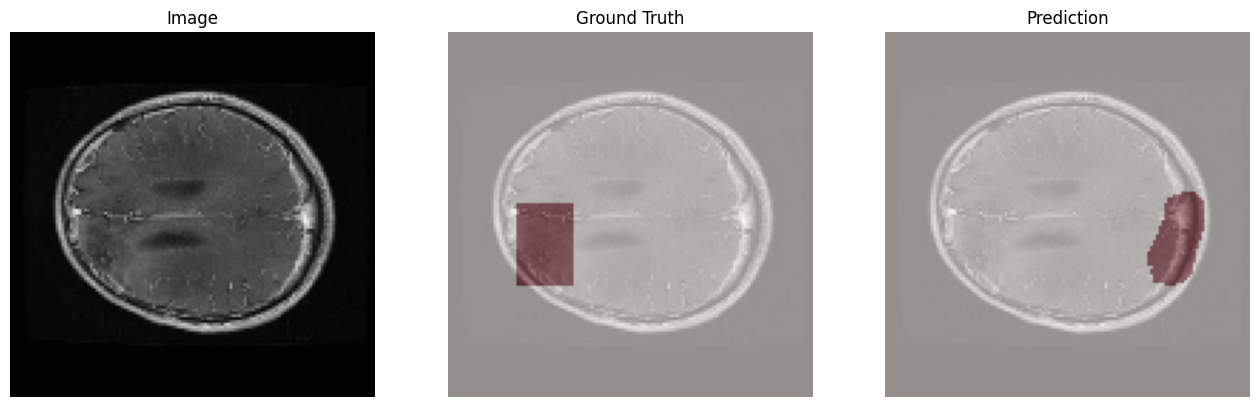


========== EPOCH 3/25 ==========



Training: 100%|██████████| 376/376 [00:52<00:00,  7.16it/s, loss=0.601]



Train Loss: 0.7341
Val Loss:   0.6460
Val IoU:    0.5249
Val Acc:    0.9760
🌟 Best IoU improved 0.3968 → 0.5249

========== EPOCH 4/25 ==========



Training: 100%|██████████| 376/376 [00:50<00:00,  7.41it/s, loss=0.541]



Train Loss: 0.5710
Val Loss:   0.5245
Val IoU:    0.5327
Val Acc:    0.9751
🌟 Best IoU improved 0.5249 → 0.5327

📊 Visual Progress Preview:


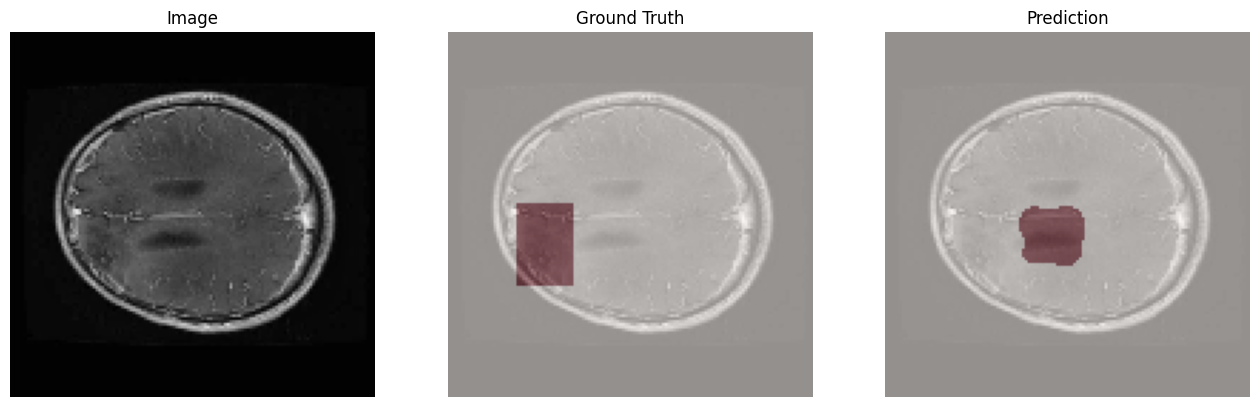


========== EPOCH 5/25 ==========



Training: 100%|██████████| 376/376 [00:42<00:00,  8.84it/s, loss=0.591]



Train Loss: 0.4612
Val Loss:   0.4686
Val IoU:    0.5448
Val Acc:    0.9787
🌟 Best IoU improved 0.5327 → 0.5448

========== EPOCH 6/25 ==========



Training: 100%|██████████| 376/376 [00:42<00:00,  8.88it/s, loss=0.203]



Train Loss: 0.3864
Val Loss:   0.4410
Val IoU:    0.5447
Val Acc:    0.9803
No improvement: 1/8

📊 Visual Progress Preview:


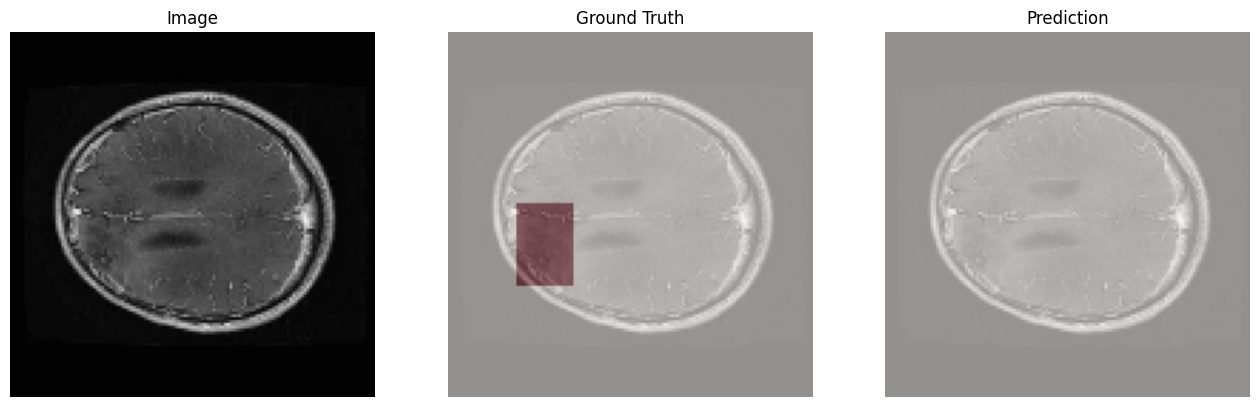


========== EPOCH 7/25 ==========



Training: 100%|██████████| 376/376 [00:47<00:00,  7.95it/s, loss=0.425]



Train Loss: 0.3534
Val Loss:   0.4015
Val IoU:    0.5697
Val Acc:    0.9798
🌟 Best IoU improved 0.5448 → 0.5697

========== EPOCH 8/25 ==========



Training: 100%|██████████| 376/376 [00:47<00:00,  7.85it/s, loss=0.252]



Train Loss: 0.3083
Val Loss:   0.3917
Val IoU:    0.5692
Val Acc:    0.9821
No improvement: 1/8

📊 Visual Progress Preview:


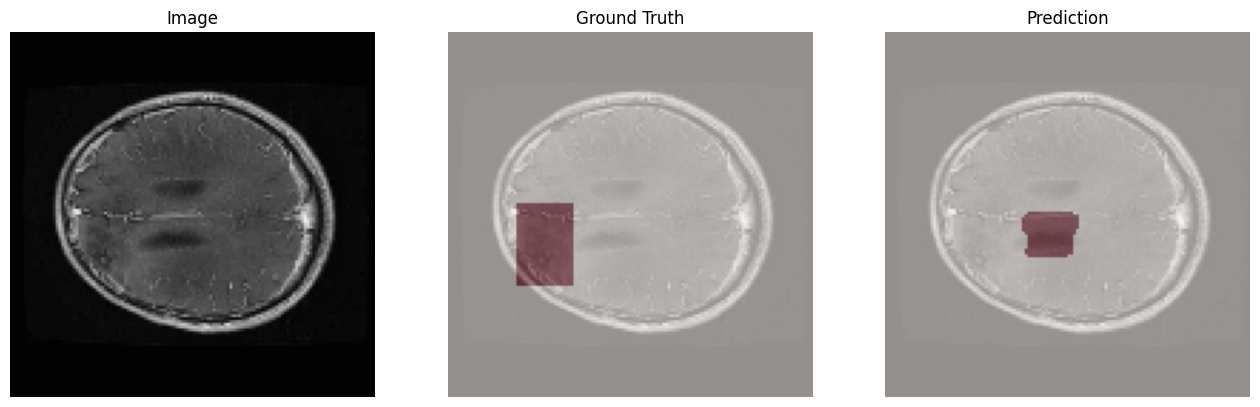


========== EPOCH 9/25 ==========



Training: 100%|██████████| 376/376 [00:49<00:00,  7.55it/s, loss=0.111]



Train Loss: 0.2764
Val Loss:   0.3525
Val IoU:    0.6025
Val Acc:    0.9828
🌟 Best IoU improved 0.5697 → 0.6025

========== EPOCH 10/25 ==========



Training: 100%|██████████| 376/376 [00:43<00:00,  8.61it/s, loss=0.186]



Train Loss: 0.2539
Val Loss:   0.4143
Val IoU:    0.5496
Val Acc:    0.9804
No improvement: 1/8

📊 Visual Progress Preview:


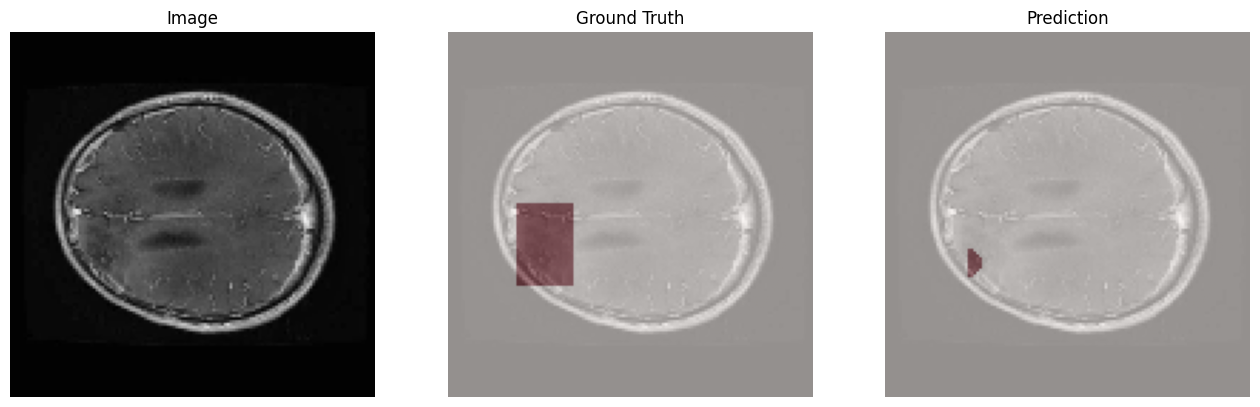


========== EPOCH 11/25 ==========



Training: 100%|██████████| 376/376 [00:19<00:00, 18.81it/s, loss=0.0746]



Train Loss: 0.2518
Val Loss:   0.3401
Val IoU:    0.6094
Val Acc:    0.9822
🌟 Best IoU improved 0.6025 → 0.6094

========== EPOCH 12/25 ==========



Training: 100%|██████████| 376/376 [00:20<00:00, 18.39it/s, loss=0.227] 



Train Loss: 0.2302
Val Loss:   0.3576
Val IoU:    0.5988
Val Acc:    0.9802
No improvement: 1/8

📊 Visual Progress Preview:


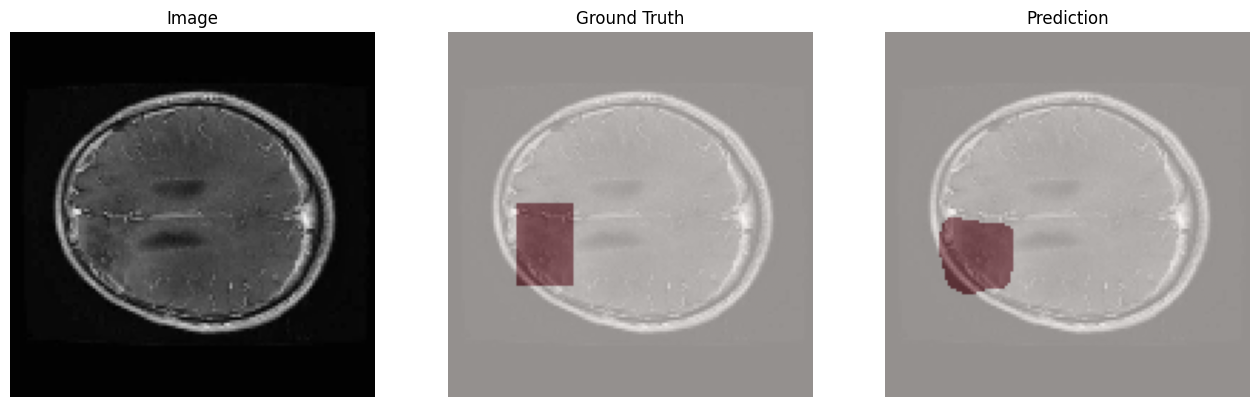


========== EPOCH 13/25 ==========



Training: 100%|██████████| 376/376 [00:21<00:00, 17.43it/s, loss=0.117] 



Train Loss: 0.2232
Val Loss:   0.3300
Val IoU:    0.6142
Val Acc:    0.9837
🌟 Best IoU improved 0.6094 → 0.6142

========== EPOCH 14/25 ==========



Training: 100%|██████████| 376/376 [00:22<00:00, 16.36it/s, loss=0.119] 



Train Loss: 0.2066
Val Loss:   0.3186
Val IoU:    0.6316
Val Acc:    0.9828
🌟 Best IoU improved 0.6142 → 0.6316

📊 Visual Progress Preview:


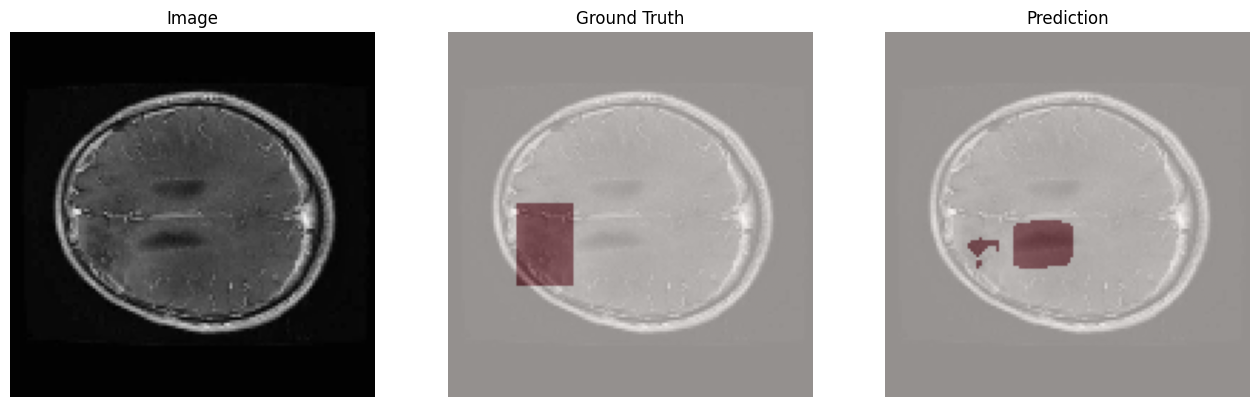


========== EPOCH 15/25 ==========



Training: 100%|██████████| 376/376 [00:21<00:00, 17.45it/s, loss=0.128] 



Train Loss: 0.1956
Val Loss:   0.3209
Val IoU:    0.6260
Val Acc:    0.9836
No improvement: 1/8

========== EPOCH 16/25 ==========



Training: 100%|██████████| 376/376 [00:21<00:00, 17.46it/s, loss=0.117] 



Train Loss: 0.1776
Val Loss:   0.3276
Val IoU:    0.6181
Val Acc:    0.9824
No improvement: 2/8

📊 Visual Progress Preview:


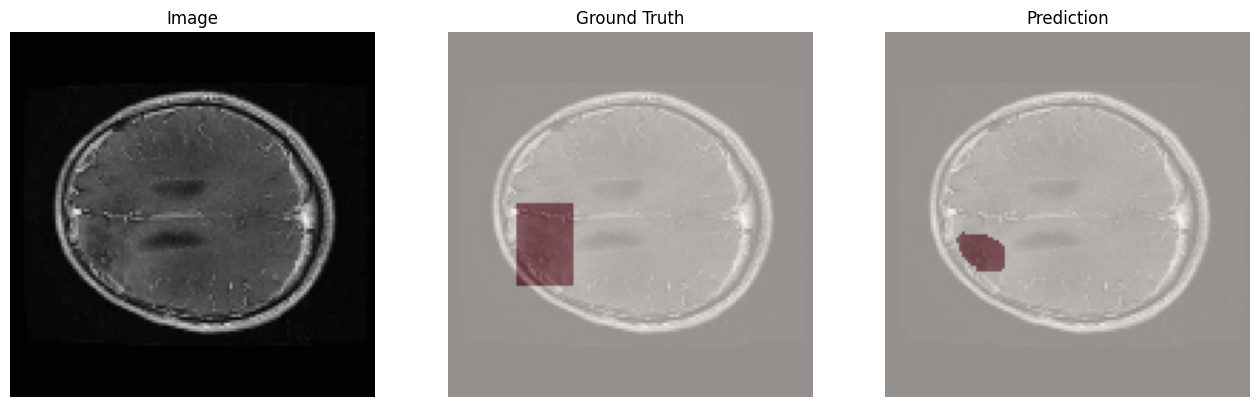


========== EPOCH 17/25 ==========



Training: 100%|██████████| 376/376 [00:22<00:00, 16.49it/s, loss=0.0957]



Train Loss: 0.1712
Val Loss:   0.3209
Val IoU:    0.6275
Val Acc:    0.9836
No improvement: 3/8

========== EPOCH 18/25 ==========



Training: 100%|██████████| 376/376 [00:23<00:00, 15.89it/s, loss=0.139] 



Train Loss: 0.1699
Val Loss:   0.2841
Val IoU:    0.6629
Val Acc:    0.9850
🌟 Best IoU improved 0.6316 → 0.6629

📊 Visual Progress Preview:


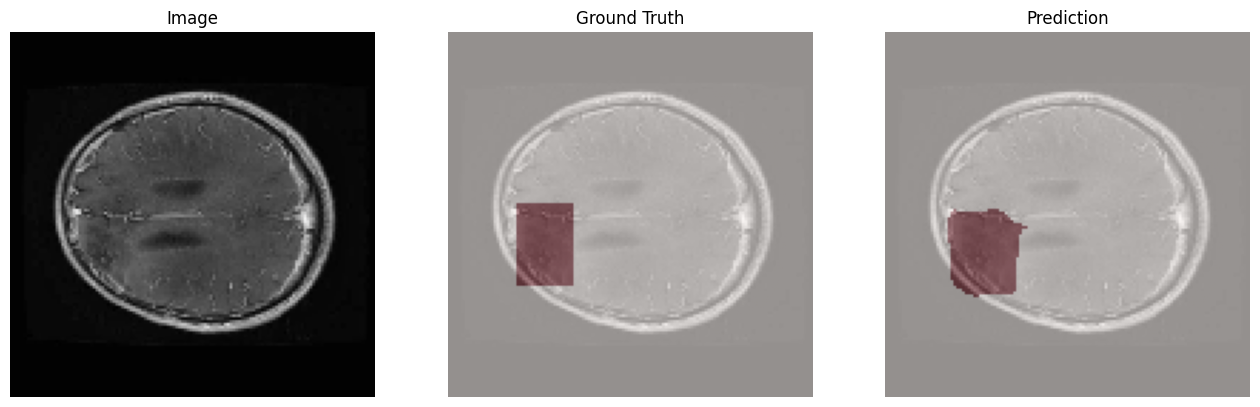


========== EPOCH 19/25 ==========



Training: 100%|██████████| 376/376 [00:23<00:00, 15.68it/s, loss=0.0812]



Train Loss: 0.1635
Val Loss:   0.3117
Val IoU:    0.6352
Val Acc:    0.9839
No improvement: 1/8

========== EPOCH 20/25 ==========



Training: 100%|██████████| 376/376 [00:23<00:00, 15.70it/s, loss=0.108] 



Train Loss: 0.1476
Val Loss:   0.3238
Val IoU:    0.6245
Val Acc:    0.9838
No improvement: 2/8

📊 Visual Progress Preview:


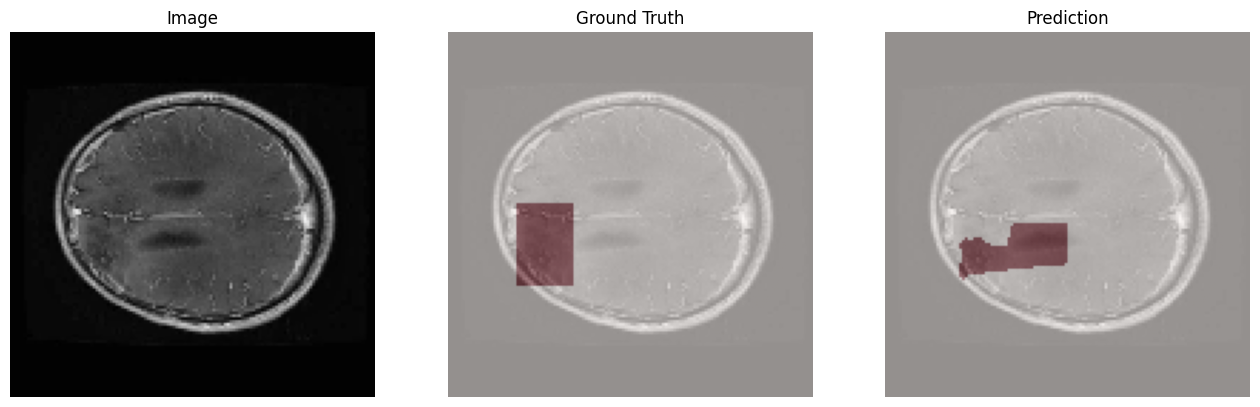


========== EPOCH 21/25 ==========



Training: 100%|██████████| 376/376 [00:24<00:00, 15.64it/s, loss=0.102] 



Train Loss: 0.1447
Val Loss:   0.3432
Val IoU:    0.6164
Val Acc:    0.9837
No improvement: 3/8

========== EPOCH 22/25 ==========



Training: 100%|██████████| 376/376 [00:23<00:00, 16.12it/s, loss=0.162] 



Train Loss: 0.1458
Val Loss:   0.3233
Val IoU:    0.6284
Val Acc:    0.9834
No improvement: 4/8

📊 Visual Progress Preview:


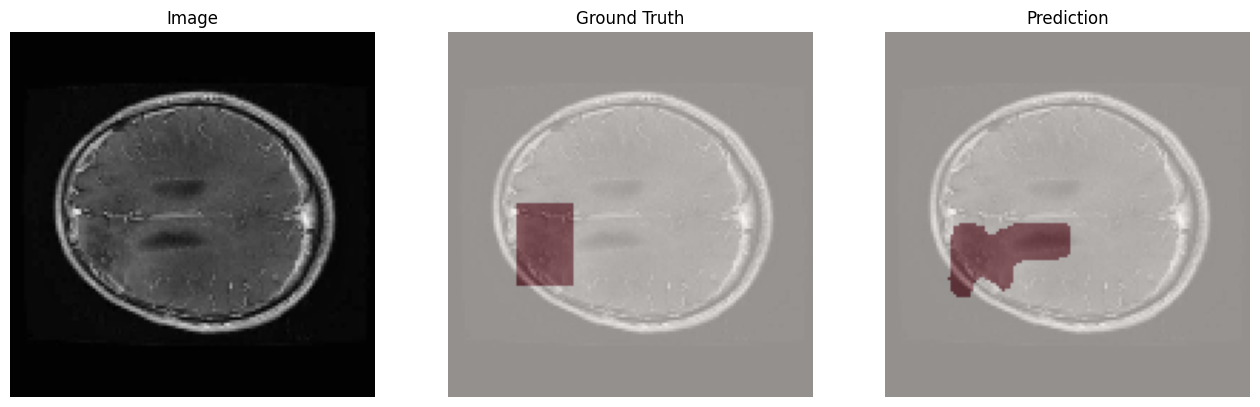


========== EPOCH 23/25 ==========



Training: 100%|██████████| 376/376 [00:23<00:00, 16.09it/s, loss=0.0761]



Train Loss: 0.1217
Val Loss:   0.2877
Val IoU:    0.6617
Val Acc:    0.9854
No improvement: 5/8

========== EPOCH 24/25 ==========



Training: 100%|██████████| 376/376 [00:22<00:00, 16.36it/s, loss=0.179] 



Train Loss: 0.1084
Val Loss:   0.2984
Val IoU:    0.6508
Val Acc:    0.9855
No improvement: 6/8

📊 Visual Progress Preview:


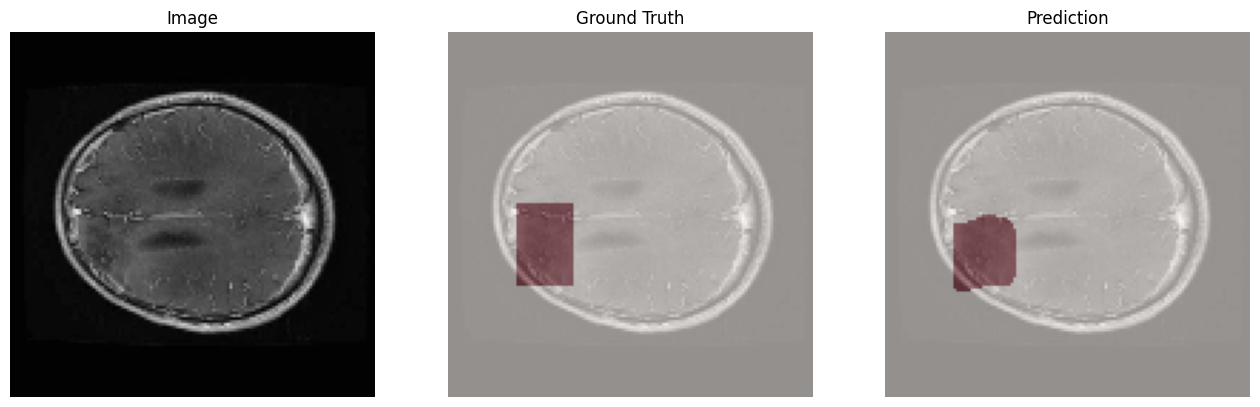


========== EPOCH 25/25 ==========



Training: 100%|██████████| 376/376 [00:22<00:00, 16.50it/s, loss=0.0985]



Train Loss: 0.0971
Val Loss:   0.3089
Val IoU:    0.6451
Val Acc:    0.9847
No improvement: 7/8

Training finished.
Best IoU achieved: 0.6628597853360353


In [93]:
# ==========================================================
# TRAINING LOOP (MPS SAFE) + PROGRESS BAR + VISUAL PREVIEW
# ==========================================================
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using:", DEVICE)

model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.5, verbose=True
)

best_iou = 0
patience = 8
counter = 0
max_epochs = 25


def show_visual_progress(model, loader):
    """Show overlay of image + ground truth + prediction."""
    model.eval()
    with torch.no_grad():
        img, mask = next(iter(loader))
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        pred = torch.sigmoid(model(img))
        pred_bin = (pred > 0.5).float()

        # Convert to numpy
        img_np = img[0].permute(1,2,0).cpu().numpy()
        img_np = img_np * 0.5 + 0.5  # unnormalize
        mask_np = mask[0,0].cpu().numpy()
        pred_np = pred_bin[0,0].cpu().numpy()

        plt.figure(figsize=(16,5))

        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(img_np)
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Ground Truth")
        plt.imshow(img_np, alpha=0.7)
        plt.imshow(mask_np, cmap="Reds", alpha=0.4)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.imshow(img_np, alpha=0.7)
        plt.imshow(pred_np, cmap="Reds", alpha=0.4)
        plt.axis("off")

        plt.show()


print("\n🚀 Starting Training...\n")

for epoch in range(1, max_epochs + 1):
    print(f"\n========== EPOCH {epoch}/{max_epochs} ==========\n")

    model.train()
    running_loss = 0

    loop = tqdm(train_loader, desc="Training", leave=True)

    for images, masks in loop:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)

    # VALIDATION
    val_loss, val_iou, val_acc = validate_one_epoch(model, val_loader, criterion)

    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val IoU:    {val_iou:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")

    scheduler.step(val_iou)

    # --- EARLY STOPPING ---
    if val_iou > best_iou:
        print(f"🌟 Best IoU improved {best_iou:.4f} → {val_iou:.4f}")
        best_iou = val_iou
        counter = 0
        torch.save(model.state_dict(), "../experiments/best_model_mps.pth")
    else:
        counter += 1
        print(f"No improvement: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # --- VISUAL PROGRESS EVERY 2 EPOCHS ---
    if epoch % 2 == 0:
        print("\n📊 Visual Progress Preview:")
        show_visual_progress(model, val_loader)

print("\nTraining finished.")
print("Best IoU achieved:", best_iou)

***

In [ ]:
# ==========================================================
# REFINED UNET128 — Wider Encoder + Stable Decoder
# Target IoU ≥ 0.70 for 128×128 rectangles
# ==========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConvR(nn.Module):
    """Conv-BN-ReLU twice with wider channels."""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class DownR(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.mp = nn.MaxPool2d(2)
        self.conv = DoubleConvR(in_c, out_c)

    def forward(self, x):
        return self.conv(self.mp(x))


class UpR(nn.Module):
    """Upsample and reduce channels BEFORE concatenation."""
    def __init__(self, in_c, out_c):
        super().__init__()
        # halve channel count before concat (fixes all channel mismatches)
        self.reduce = nn.Conv2d(in_c, out_c, kernel_size=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConvR(out_c*2, out_c)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.reduce(x1)  # channel reduction

        # spatial padding
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNetRefined128(nn.Module):
    """
    Wider encoder, reduced-decoder, optimized for MPS speed.
    This is the sweet-spot architecture for rectangular masks.
    """
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        # WIDER ENCODER (critical for reaching ≥0.70 IoU)
        self.inc   = DoubleConvR(n_channels, 96)
        self.down1 = DownR(96,   192)
        self.down2 = DownR(192,  384)
        self.down3 = DownR(384,  768)
        self.down4 = DownR(768, 1024)

        # bottleneck dropout to prevent overfitting
        self.drop = nn.Dropout(0.4)

        # DECODER — reduced channels for MPS speed
        self.up1 = UpR(1024, 384)
        self.up2 = UpR(384, 192)
        self.up3 = UpR(192, 96)
        self.up4 = UpR(96,  64)

        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x5 = self.drop(x5)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        return self.out(x)